Importing libraries

In [1]:
# Import pytorch basic functions/classes
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Import torchvision functions/classes for MNIST import and data loaders
import torchvision
import torchvision.transforms as transforms

# Other imports
import pandas as pd
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt


# Set device on which code is run
device = 'cuda'

Defining support functions

In [2]:
# Define support function used to convert label to one-hot encoded tensor
def convert_labels(labels):
    target = torch.zeros([len(labels), 10], dtype=torch.float32)
    for i, l in enumerate(labels):
      target[i][l] = 1.0
    return target

Define our network model (the hidden layers size is specified through the constructor)

In [3]:
# Define MLP model and its layers
class Model(nn.Module):

    def __init__(self, hidden_size=1200, dropout=0.0, hidden_dropout=0.0):
        super(Model, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.hidden1 = nn.Linear(784, hidden_size, bias=True)
        self.hidden1_dropout = nn.Dropout(hidden_dropout)
        self.hidden2 = nn.Linear(hidden_size, hidden_size, bias=True)
        self.hidden2_dropout = nn.Dropout(hidden_dropout)
        self.hidden3 = nn.Linear(hidden_size, 10, bias=True)

    def forward(self, x):

        x = self.dropout(x)
        x = F.relu(self.hidden1(x))
        x = self.hidden1_dropout(x)
        x = F.relu(self.hidden2(x))
        x = self.hidden2_dropout(x)
        x = self.hidden3(x)
        return x#, F.softmax(x)

Downloading MNIST dataset

In [4]:
# Define transform from PIL image to tensor and normalize to 1x768 pixels
train_transform = transforms.Compose([
  transforms.RandomAffine(0, (1/14, 1/14)),
  transforms.ToTensor(),
  transforms.Normalize((0.5,), (0.5,))
])

test_transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.5,), (0.5,))
])

# Set batch size for data loaders
batch_size = 128

# (Down)load training set
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

# (Down)load test set
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# (Down)load training set without a specific digit
trainset_noDigit = torchvision.datasets.MNIST(root='./data', train=True, download=True)

#   Set here the digit to exclude
idx = trainset_noDigit.train_labels!=3

trainset_noDigit.targets = trainset_noDigit.targets[idx]
trainset_noDigit.data = trainset_noDigit.data[idx]
trainset_noDigit.transform = train_transform

trainloader_noDigit = torch.utils.data.DataLoader(trainset_noDigit, batch_size=batch_size, shuffle=True, num_workers=2)

'''examples = enumerate(trainloader)
batch_idx, (example_data, example_targets) = next(examples)

import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
#fig'''

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


'examples = enumerate(trainloader)\nbatch_idx, (example_data, example_targets) = next(examples)\n\nimport matplotlib.pyplot as plt\n\nfig = plt.figure()\nfor i in range(6):\n  plt.subplot(2,3,i+1)\n  plt.tight_layout()\n  plt.imshow(example_data[i][0], cmap=\'gray\', interpolation=\'none\')\n  plt.title("Ground Truth: {}".format(example_targets[i]))\n  plt.xticks([])\n  plt.yticks([])\n#fig'

Training the Deep Teacher Neural Network

In [5]:
# Setup model and move it to the GPU
net = Model(dropout=0.2, hidden_dropout=0.5)
net.to(device)

# Set up loss function and optimizer: 
#     using cross entropy loss because it's better for classification task

learning_rate = 0.01
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr= learning_rate, momentum=0.9)
#optimizer = torch.optim.Adam(net.parameters(), lr=0.0001, weight_decay=0.00001)

# Run over 100 epochs (1 epoch = visited all items in dataset)
for epoch in range(1000):

    running_loss = 0.0
    total = 0

    if(epoch%100 == 0 and epoch != 0):

      learning_rate = learning_rate * 0.5 #- (0.001) # or maybe decrease by (learning_rate * 0.1)
      optimizer = optim.SGD(net.parameters(), lr= learning_rate, momentum=0.9)

    for i, data in enumerate(trainloader, 0):
        

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = torch.flatten(inputs, start_dim=1).to(device)

        # This for not cross entropy
        #target = convert_labels(labels).to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        target = labels.to(device).long()
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        total += len(data)

        # print statistics
        running_loss += loss.item()
    # print every epoch
    print('[%d] loss: %.3f' % (epoch + 1, running_loss / total))

print('Finished Training')

# Save model after having finished training
PATH = './mnist_dropout_100_epoch.pth'
torch.save(net.state_dict(), PATH)

print('Saved Model')

[1] loss: 0.517
[2] loss: 0.264
[3] loss: 0.202
[4] loss: 0.173
[5] loss: 0.155
[6] loss: 0.146
[7] loss: 0.133
[8] loss: 0.125
[9] loss: 0.117
[10] loss: 0.111
[11] loss: 0.108
[12] loss: 0.102
[13] loss: 0.099
[14] loss: 0.097
[15] loss: 0.092
[16] loss: 0.089
[17] loss: 0.088
[18] loss: 0.086
[19] loss: 0.085
[20] loss: 0.082
[21] loss: 0.080
[22] loss: 0.079
[23] loss: 0.076
[24] loss: 0.076
[25] loss: 0.075
[26] loss: 0.075
[27] loss: 0.072
[28] loss: 0.071
[29] loss: 0.071
[30] loss: 0.070
[31] loss: 0.068
[32] loss: 0.068
[33] loss: 0.066
[34] loss: 0.066
[35] loss: 0.065
[36] loss: 0.066
[37] loss: 0.064
[38] loss: 0.063
[39] loss: 0.062
[40] loss: 0.062
[41] loss: 0.062
[42] loss: 0.060
[43] loss: 0.060
[44] loss: 0.061
[45] loss: 0.058
[46] loss: 0.058
[47] loss: 0.057
[48] loss: 0.058
[49] loss: 0.056
[50] loss: 0.057
[51] loss: 0.056
[52] loss: 0.056
[53] loss: 0.056
[54] loss: 0.055
[55] loss: 0.055
[56] loss: 0.053
[57] loss: 0.054
[58] loss: 0.052
[59] loss: 0.054
[60] l

Run Deep Teacher model on test set

Accuracy of the network on the 10000 test images: 99 % (58 wrong out of 10000)


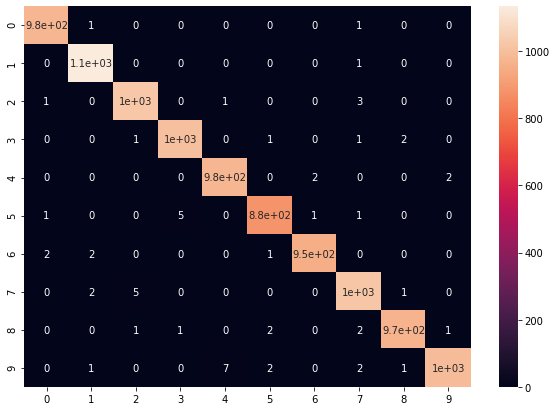

In [7]:
# Instantiate model and load saved network parameters
net = Model().to(device)
net.load_state_dict(torch.load(PATH))

# Run model on test set and determine accuracy
correct = 0
total = 0
wrong = np.zeros((10,10))

with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs = torch.flatten(inputs, start_dim=1).to(device)
        target = convert_labels(labels).to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        _, target = torch.max(target.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        for i, val in enumerate(predicted):
          wrong[target[i]][val] += 1

# Output model accuracy to user
print('Accuracy of the network on the 10000 test images: %d %% (%d wrong out of %d)' % (
    100 * correct / total, total - correct, total))
#print(" "+str([0,1,2,3,4,5,6,7,8,9]))
#print(wrong)

# Plot confusion matrix
df_cm = pd.DataFrame(wrong, index = [i for i in "0123456789"],
                  columns = [i for i in "0123456789"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [8]:
# Custom student loss: linear combination of 2 cross-entropy losses
#     The first one between student output and hard labels
#     The second one between student output and soft labels from teacher

def student_loss(outputs, labels, teacher_outputs, alpha, temperature):

    #loss = torch.mean((weight*(outputA - targetA)**2) + (1-weight)*(outputB-targetB)**2)

    #loss = weight*(F.cross_entropy(outputA, targetA)) + (1-weight)*(F.cross_entropy(outputB, targetB))

    KD_loss = nn.KLDivLoss()(F.log_softmax(outputs/T, dim=1),
                             F.softmax(teacher_outputs/T, dim=1)) * (alpha * T * T) + \
              F.cross_entropy(outputs, labels) * (1. - alpha)

    return KD_loss

Train student model to mimic the teacher

In [8]:
# Setup student model and move it to the GPU
student_net = Model(hidden_size = 800)
student_net.to(device)

# Set up loss function and optimizer

optimizer = optim.SGD(student_net.parameters(), lr=0.001, momentum=0.9)
#optimizer = torch.optim.Adam(student_net.parameters(), lr=0.0001)

# Run over 100 epochs (1 epoch = visited all items in dataset)
for epoch in range(1000):
    running_loss = 0.0
    total = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = torch.flatten(inputs, start_dim=1).to(device)
        target = labels.to(device).long() #convert_labels(labels).to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # Set temperature and the weights for losses linear combination
        w = 0.7
        T = 20

        # Compute soft labels using deep teacher model previously trained
        outputs_teacher = net(inputs)
        #soft_labels = F.softmax(outputs_teacher/T, dim = 1)

        # Abomination to obtain hard_labels for custom cross entropy loss
        #teacher_hard_labels = torch.from_numpy(np.array([np.argmax(l.cpu().detach().numpy()) for l in soft_labels])).to(device).long()

        # Student forward + backward + optimize
        outputs_stud = student_net(inputs)
        #outputs_stud = F.softmax(output_stud/T, dim = 1)
        
        loss = student_loss(outputs_stud, target, outputs_teacher, w, T)
        loss.backward()
        optimizer.step()

        total += len(data)

        # print statistics
        running_loss += loss.item()
    # print every epoch
    print('[%d] loss: %.3f' % (epoch + 1, running_loss / total))

print('Finished Training')

# Save model after having finished training
STUD_PATH = './mnist_student_100_epoch.pth'
torch.save(student_net.state_dict(), STUD_PATH)

print('Saved Model')

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2352: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


[1] loss: 1.413
[2] loss: 1.018
[3] loss: 0.793
[4] loss: 0.707
[5] loss: 0.639
[6] loss: 0.572
[7] loss: 0.506
[8] loss: 0.446
[9] loss: 0.391
[10] loss: 0.347
[11] loss: 0.314
[12] loss: 0.285
[13] loss: 0.261
[14] loss: 0.241
[15] loss: 0.225
[16] loss: 0.209
[17] loss: 0.196
[18] loss: 0.184
[19] loss: 0.172
[20] loss: 0.163
[21] loss: 0.156
[22] loss: 0.147
[23] loss: 0.141
[24] loss: 0.134
[25] loss: 0.127
[26] loss: 0.122
[27] loss: 0.117
[28] loss: 0.113
[29] loss: 0.110
[30] loss: 0.105
[31] loss: 0.102
[32] loss: 0.099
[33] loss: 0.096
[34] loss: 0.093
[35] loss: 0.090
[36] loss: 0.088
[37] loss: 0.086
[38] loss: 0.084
[39] loss: 0.081
[40] loss: 0.079
[41] loss: 0.078
[42] loss: 0.077
[43] loss: 0.075
[44] loss: 0.074
[45] loss: 0.071
[46] loss: 0.070
[47] loss: 0.069
[48] loss: 0.068
[49] loss: 0.067
[50] loss: 0.066
[51] loss: 0.064
[52] loss: 0.064
[53] loss: 0.062
[54] loss: 0.061
[55] loss: 0.060
[56] loss: 0.060
[57] loss: 0.059
[58] loss: 0.058
[59] loss: 0.057
[60] l

Running student model on test set

Accuracy of the network on the 10000 test images: 99 % (65 wrong out of 10000)


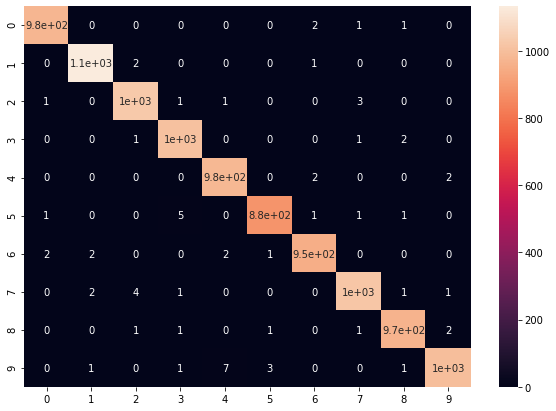

In [9]:
stud_net = Model(hidden_size = 800).to(device)
stud_net.load_state_dict(torch.load(STUD_PATH))

# Run model on test set and determine accuracy
correct = 0
total = 0
wrong = np.zeros((10,10))
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs = torch.flatten(inputs, start_dim=1).to(device)
        target = convert_labels(labels).to(device)
        outputs = stud_net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        _, target = torch.max(target.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        for i, val in enumerate(predicted):
          wrong[target[i]][val] += 1

# Output model accuracy to user
print('Accuracy of the network on the 10000 test images: %d %% (%d wrong out of %d)' % (
    100 * correct / total, total - correct, total))
#print(" "+str([0,1,2,3,4,5,6,7,8,9]))
#print(wrong)

# Plot confusion matrix
df_cm = pd.DataFrame(wrong, index = [i for i in "0123456789"],
                  columns = [i for i in "0123456789"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

Training student model on test set without a digit

In [9]:
# Setup student model and move it to the GPU
student_net = Model(hidden_size = 800)
student_net.to(device)

# Set up optimizer
optimizer = optim.SGD(student_net.parameters(), lr=0.001, momentum=0.9)

# Run over 100 epochs (1 epoch = visited all items in dataset)
for epoch in range(1000):
    running_loss = 0.0
    total = 0
    for i, data in enumerate(trainloader_noDigit, 0):
      
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = torch.flatten(inputs, start_dim=1).to(device)
        target = labels.to(device).long()
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # Set temperature and the weights for losses linear combination
        w = 0.7
        T = 20

        # Compute soft labels using deep teacher model previously trained
        outputs_teacher = net(inputs)

        # Student forward + backward + optimize
        outputs_stud = student_net(inputs)
        
        loss = student_loss(outputs_stud, target, outputs_teacher, w, T)
        loss.backward()
        optimizer.step()

        total += len(data)

        # print statistics
        running_loss += loss.item()
    # print every epoch
    print('[%d] loss: %.3f' % (epoch + 1, running_loss / total))

print('Finished Training')

# Save model after having finished training
STUD_PATH = './mnist_student_no_digit.pth'
torch.save(student_net.state_dict(), STUD_PATH)

print('Saved Model')

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2352: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


[1] loss: 1.325
[2] loss: 0.975
[3] loss: 0.766
[4] loss: 0.678
[5] loss: 0.617
[6] loss: 0.560
[7] loss: 0.508
[8] loss: 0.460
[9] loss: 0.415
[10] loss: 0.374
[11] loss: 0.340
[12] loss: 0.312
[13] loss: 0.284
[14] loss: 0.262
[15] loss: 0.241
[16] loss: 0.224
[17] loss: 0.208
[18] loss: 0.193
[19] loss: 0.182
[20] loss: 0.171
[21] loss: 0.160
[22] loss: 0.150
[23] loss: 0.142
[24] loss: 0.136
[25] loss: 0.130
[26] loss: 0.124
[27] loss: 0.119
[28] loss: 0.114
[29] loss: 0.110
[30] loss: 0.106
[31] loss: 0.102
[32] loss: 0.099
[33] loss: 0.096
[34] loss: 0.093
[35] loss: 0.090
[36] loss: 0.088
[37] loss: 0.086
[38] loss: 0.084
[39] loss: 0.082
[40] loss: 0.081
[41] loss: 0.078
[42] loss: 0.076
[43] loss: 0.074
[44] loss: 0.074
[45] loss: 0.072
[46] loss: 0.071
[47] loss: 0.070
[48] loss: 0.068
[49] loss: 0.067
[50] loss: 0.066
[51] loss: 0.065
[52] loss: 0.064
[53] loss: 0.063
[54] loss: 0.062
[55] loss: 0.062
[56] loss: 0.060
[57] loss: 0.059
[58] loss: 0.059
[59] loss: 0.058
[60] l

Test student traint on digitless training set


Accuracy of the network on the 10000 test images: 98 % (141 wrong out of 10000)


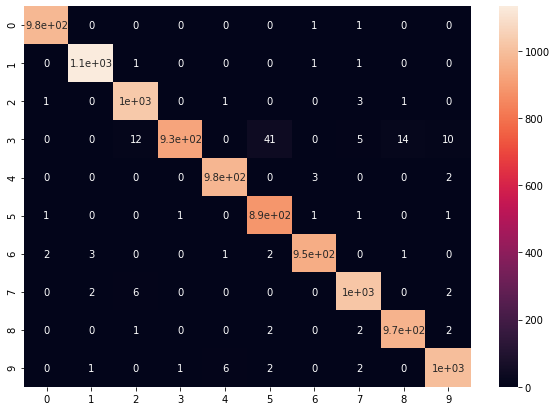

In [10]:
stud_net = Model(hidden_size = 800).to(device)
stud_net.load_state_dict(torch.load(STUD_PATH))

# Run model on test set and determine accuracy
correct = 0
total = 0
wrong = np.zeros((10,10))
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs = torch.flatten(inputs, start_dim=1).to(device)
        target = convert_labels(labels).to(device)
        outputs = stud_net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        _, target = torch.max(target.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        for i, val in enumerate(predicted):
          wrong[target[i]][val] += 1

# Output model accuracy to user
print('Accuracy of the network on the 10000 test images: %d %% (%d wrong out of %d)' % (
    100 * correct / total, total - correct, total))
#print(" "+str([0,1,2,3,4,5,6,7,8,9]))
#print(wrong)

# Plot confusion matrix
df_cm = pd.DataFrame(wrong, index = [i for i in "0123456789"],
                  columns = [i for i in "0123456789"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)